In [8]:
from torch.autograd import Variable
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torchvision.transforms as T
import PIL
import matplotlib.pyplot as plt

In [9]:
class ContentLoss(nn.Module):
    def forward(self, content_weight, content_current, content_original):
        loss = content_weight * torch.sum(torch.square(content_current - content_original))
        return loss
    
class StyleLoss(nn.Module):
    def gram_matrix(self, features, normalize=True):
        N, C, H, W = features.size()
        features = torch.reshape(features, (N, C, -1))
        if normalize == True:
            gram = torch.bmm(features, features.permute(0, 2, 1))/float(H*W*C)
        else:
            gram = torch.bmm(features, features.permute(0, 2, 1))
        return gram


    def forward(self, feats, style_layers, style_targets, style_weights):
        loss = 0
        for i in range(len(style_layers)):
            gram_mat = self.gram_matrix(feats[style_layers[i]])
            loss += style_weights[i] * \
                torch.sum(torch.pow(gram_mat - style_targets[i], 2))
        return loss
    
class TotalVariationLoss(nn.Module):
    def forward(self, img, tv_weight):
        w_var = torch.sum(torch.pow(img[:,:,:,:-1] - img[:,:,:,1:], 2))
        h_var = torch.sum(torch.pow(img[:,:,:-1,:] - img[:,:,1:,:], 2))

        loss = tv_weight * (w_var + h_var)

        return loss

In [10]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)


# Preprocess the image
def preprocess(img, size=512):
    img = img.convert("RGB")
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


# Define method to extract features from the image using the CNN
def extract_features(x, cnn):
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

# Define the Gram matrix computation
def gram_matrix(features, normalize=True):
    N, C, H, W = features.size()
    features = torch.reshape(features, (N, C, -1))
    if normalize == True:
        gram = torch.bmm(features, features.permute(0, 2, 1))/float(H*W*C)
    else:
        gram = torch.bmm(features, features.permute(0, 2, 1))
    return gram

# Define method to deprocess the image
def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[
                    1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(
            mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

# Define the style transfer method
def style_transfer(name, content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, content_loss, style_loss, tv_loss, cnn, dtype,
                   init_random=False):
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size)
    content_img_var = Variable(content_img.type(dtype))
    feats = extract_features(content_img_var, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(PIL.Image.open(style_image), size=style_size)
    style_img_var = Variable(style_img.type(dtype))
    feats = extract_features(style_img_var, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialise output image to content image or noise
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1)
    else:
        img = content_img.clone().type(dtype)

    img_var = Variable(img, requires_grad=True)

    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    optimizer = torch.optim.Adam([img_var], lr=initial_lr)

    for t in range(200):
        if t < 190:
            img.clamp_(-1.5, 1.5)
        feats = extract_features(img_var, cnn)

        optimizer.zero_grad()
        cont_loss = content_loss(
            content_weight, feats[content_layer], content_target)
        st_loss = style_loss(feats, style_layers,
                             style_targets, style_weights)
        t_loss = tv_loss(img_var, tv_weight)
        loss = cont_loss + st_loss + t_loss
        loss.backward(retain_graph=True)

        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img_var], lr=decayed_lr)

        optimizer.step()

    # Deprocess the images for plotting
    content_img = deprocess(content_img.cpu())
    style_img = deprocess(style_img.cpu())
    img = deprocess(img_var.data.cpu())

    # Plotting
    plt.figure(figsize=(10, 5))

    # Content image
    plt.subplot(1, 3, 1)
    plt.imshow(content_img)
    plt.axis('off')
    plt.title('Content Image')

    # Style image
    plt.subplot(1, 3, 2)
    plt.imshow(style_img)
    plt.axis('off')
    plt.title('Style Image')

    # Output image
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Output Image')

    plt.show()


    return img

In [11]:
content_loss = ContentLoss()
style_loss = StyleLoss()
tv_loss = TotalVariationLoss()
dtype = torch.FloatTensor
cnn = torchvision.models.squeezenet1_1(pretrained=True).features

/Users/yennybae/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yennybae/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
params = {
    'name': 'composition_vii_tubingen',
    'content_image': 'images/korea.png',
    'style_image': 'images/starry_night.jpg',
    'image_size': 192,
    'style_size': 512,
    'content_layer': 3,
    'content_weight': 5e-2,
    'style_layers': (1, 4, 6, 7),
    'style_weights': (40000, 1000, 24, 2),
    'tv_weight': 5e-2,
    'content_loss': content_loss,
    'style_loss': style_loss,
    'tv_loss': tv_loss,
    'cnn': cnn,
    'dtype': dtype
}

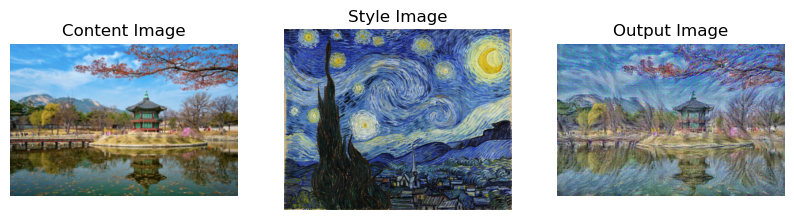

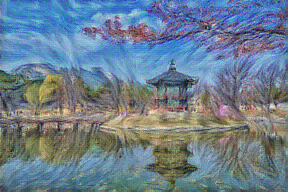

In [6]:
style_transfer(**params)